<a href="https://colab.research.google.com/github/bismillahkani/object-detection-rcnn-family/blob/main/Module2a_ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this code demo we will see how to implement different techniques of object detection such as,
1. Intersection over Union
2. Region proposals
3. Non-max suppression

## Generalized Intersection over Union (IoU)

https://giou.stanford.edu/GIoU.pdf

<img src="https://www.programmersought.com/images/223/64295275bb44ff2f723800805ca4b7ef.png" width="400"/>

In [ ]:
from PIL import Image, ImageDraw
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [ ]:
def calculate_iou_giou(bP,bG):
  ''' Returns iou and giou of two bounding boxes'''
  #unpack the box co-ordinates
  x1P, y1P, x2P, y2P = bP
  x1G, y1G, x2G, y2G = bG
  #ensure correct co-ordinates
  x1P_hat = min(x1P, x2P)
  x2P_hat = max(x1P, x2P)
  y1P_hat = min(y1P, y2P)
  y2P_hat = max(y1P, y2P)
  #bounding box area
  areaG = (x2G - x1G) * (y2G - y1G)
  areaP = (x2P_hat - x1P_hat) * (y2P_hat - y1P_hat)
  #intersection area
  x1I = max(x1P_hat, x1G)
  x2I = min(x2P_hat, x2G)
  y1I = max(y1P_hat, y1G)
  y2I = min(y2P_hat, y2G)
  if ((x2I > x1I) & (y2I > y1I)):
    areaI = (x2I - x1I) * (y2I - y1I)
  else:
    areaI = 0  
  #convex hull area
  x1C = min(x1P_hat, x1G)
  x2C = max(x1P_hat, x2G)
  y1C = min(y1P_hat, y1G)
  y2C = max(y2P_hat, y2G)
  areaC = (x2C - x1C) * (y2C - y1C)
  #union area
  areaU = areaP + areaG - areaI
  iou = areaI / areaU
  giou = iou - ((areaC - areaU)/areaC)
  return iou, giou

In [ ]:
def plot_results(pil_img, ious, boxes):
    plt.figure(figsize=(8,6))
    plt.imshow(pil_img)
    ax = plt.gca()
    for iou, (xmin, ymin, xmax, ymax), c in zip(ious, boxes, COLORS):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{iou:0.2f}'
        ax.text(xmin, ymin, text, fontsize=12,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
url = 'https://www.burkemeadlawyers.com.au/wp-content/uploads/2017/03/Pedestrians.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.resize((int(img.size[0] * 0.5), int(img.size[1] * 0.5)))
draw = ImageDraw.Draw(img)
bg = [190.0, 20.0, 260.0, 240.0]
draw.rectangle(bg, outline='green', width=2)
predictions = [[185.0, 20.0, 255.0, 240.0], 
               [180.0, 5.0, 250.0, 225.0],
               [10.0, 35.0, 80.0, 230.0],
               [270.0, 35.0, 340.0, 230.0]]
COLORS = ['yellow', 'cyan', 'red', 'magenta']
ious = []
gious = []
for bp in predictions:
  iou, giou = calculate_iou_giou(bg, bp)
  ious.append(iou)
  gious.append(giou)

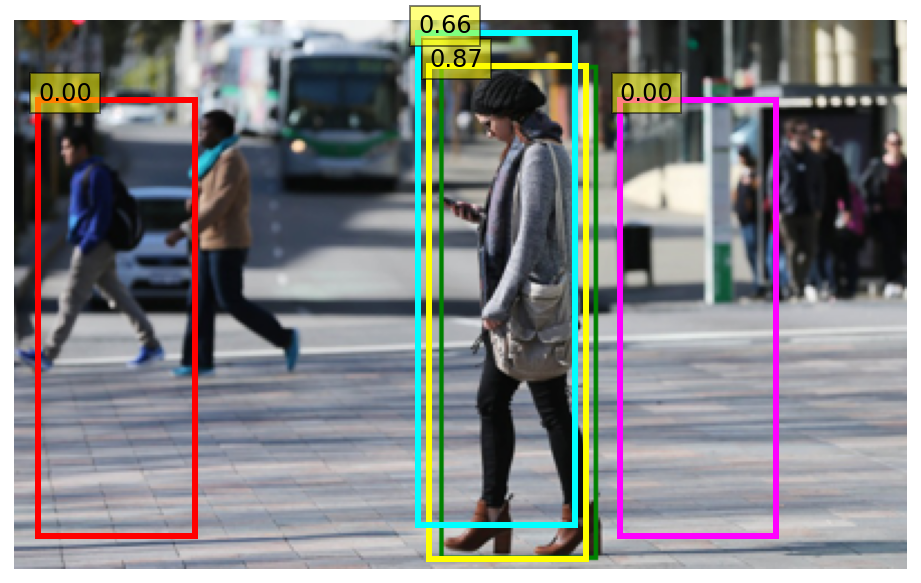

In [ ]:
plot_results(img, ious, predictions)

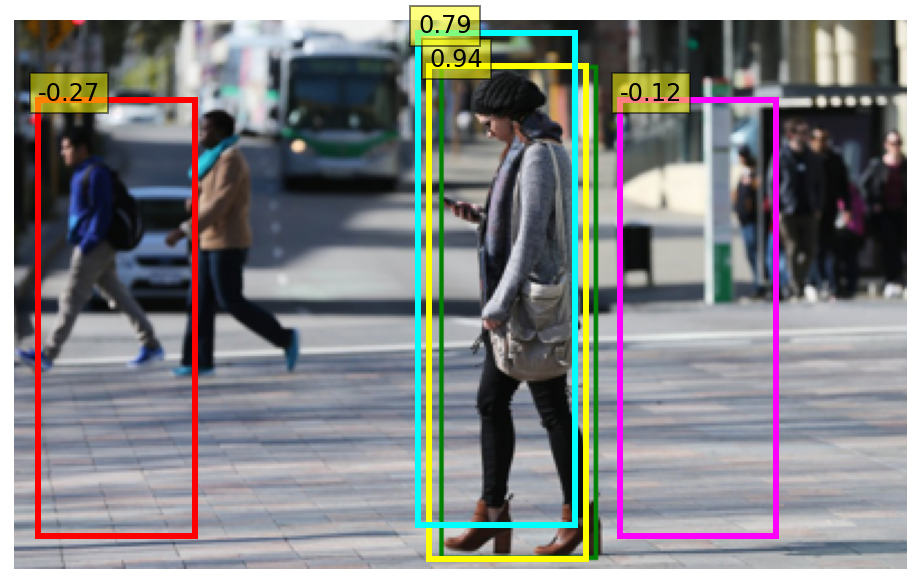

In [ ]:
plot_results(img, gious, predictions)

## Selective Search

In [ ]:
import cv2
import numpy as np
import random

In [ ]:
# read unage and convert to opencv format
img = Image.open(BytesIO(response.content))
img = img.resize((int(img.size[0] * 0.5), int(img.size[1] * 0.5)))

im = img.convert('RGB')
im = np.array(im)
im = im[:, :, ::-1].copy() 

# use opencv library for selective search
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast() # set to fast mode

# extract region proposals
rects = ss.process().tolist()

In [ ]:
def plot_regions(pil_img, boxes):
    plt.figure(figsize=(8,6))
    plt.imshow(pil_img)
    ax = plt.gca()
    for (xmin, ymin, xmax, ymax) in boxes:
      c = [random.randint(0, 1) for j in range(0, 3)]
      ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=1))
    plt.axis('off')
    plt.show()

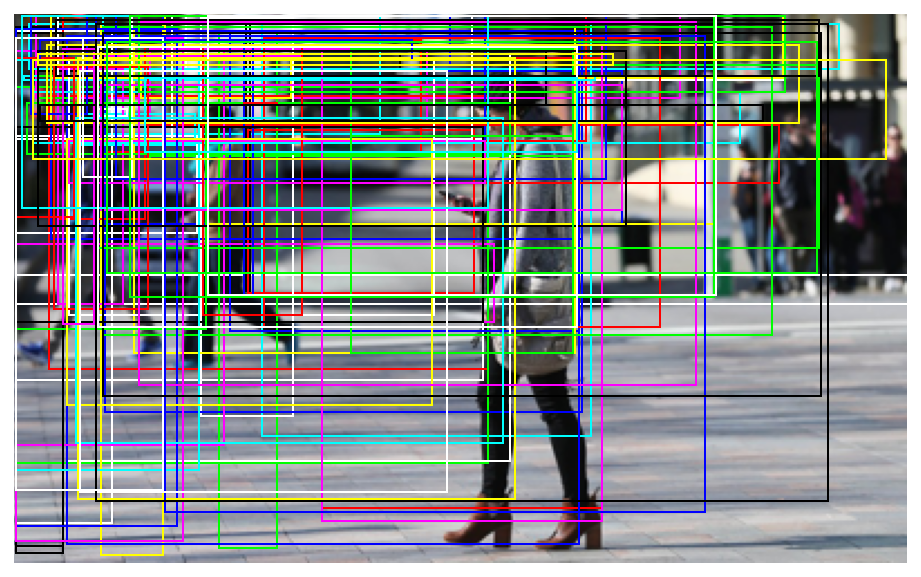

In [ ]:
plot_regions(img, rects[0:100])

## Non-Max Suppression

source : https://github.com/bruceyang2012/nms_python/blob/master/nms.py

In [ ]:
def non_max_suppression_fast(boxes, probs=None, overlapThresh=0.3):
    
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].tolist()

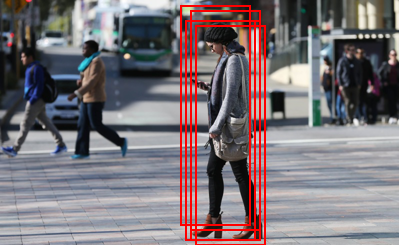

In [ ]:
url = 'https://www.burkemeadlawyers.com.au/wp-content/uploads/2017/03/Pedestrians.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.resize((int(img.size[0] * 0.5), int(img.size[1] * 0.5)))
draw = ImageDraw.Draw(img)
bg = [190.0, 20.0, 260.0, 240.0]

predictions = [[190.0, 20.0, 260.0, 240.0],
               [185.0, 20.0, 255.0, 240.0], 
               [180.0, 5.0, 250.0, 225.0],
               [195.0, 25.0, 265.0, 245.0],
               [190.0, 10.0, 260.0, 230.0]]

probs = [0.9, 0.8, 0.6, 0.83, 0.7]

for box in predictions:
  draw.rectangle(box, outline='red', width=2)

img

In [ ]:
picked = non_max_suppression_fast(np.array(predictions), probs, overlapThresh=0.5)
picked

[[190.0, 20.0, 260.0, 240.0]]

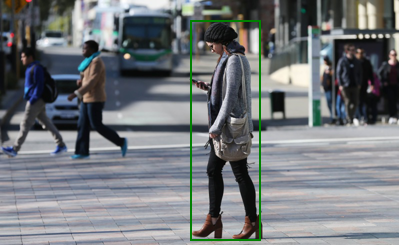

In [ ]:
img = Image.open(BytesIO(response.content))
img = img.resize((int(img.size[0] * 0.5), int(img.size[1] * 0.5)))
draw = ImageDraw.Draw(img)
for box in picked: 
  draw.rectangle(box, outline='green', width=2)
img

## Summary

Techniques learned:

1. Intersection over Union and Generalized IoU. Their differences. 
2. Region proposal using Selective Search using opencv 
3. Non-max suppression python implementation